## CNN  en sepecifier une station

In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers , callbacks,optimizers,models
import matplotlib.pyplot as plt

traite time serise data 

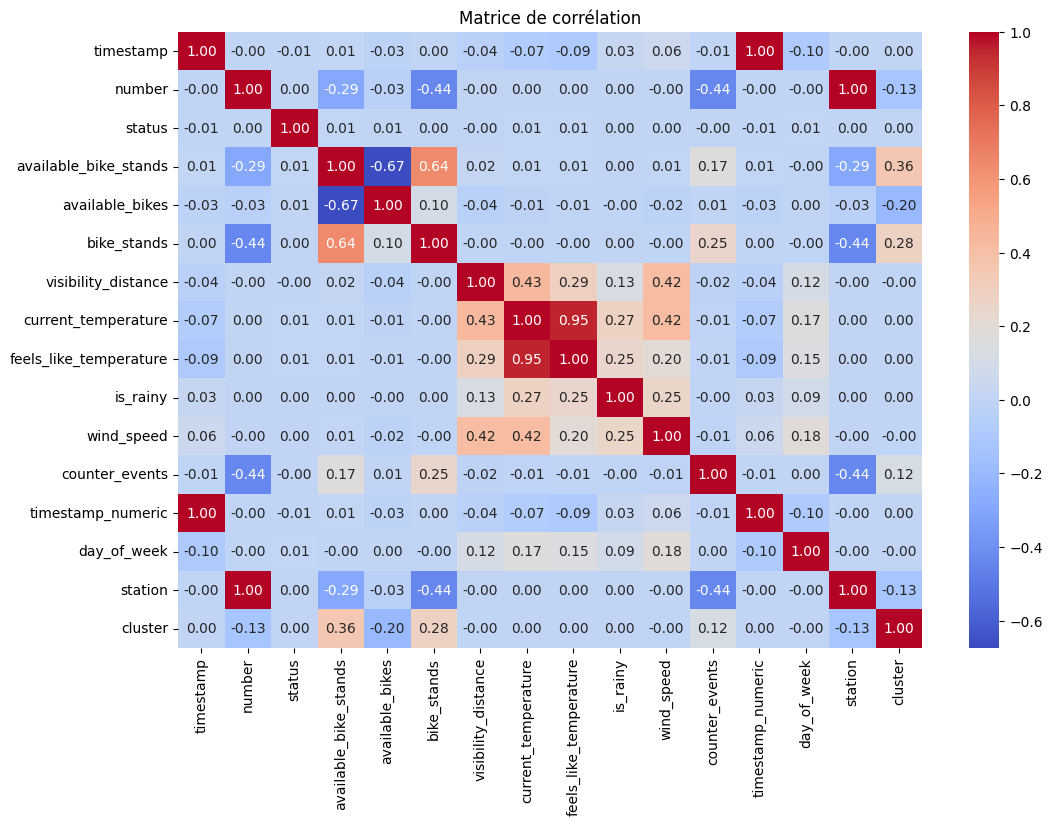

Index(['number', 'status', 'bike_stands', 'visibility_distance',
       'current_temperature', 'feels_like_temperature', 'wind_speed',
       'counter_events', 'timestamp_numeric', 'day_of_week'],
      dtype='object')


In [174]:

from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold


# Charger les données
file_path = '../data/merged_all_bikes_weather_events.csv'
clustered_stations_path = '../data/clustered_stations.csv'

data = pd.read_csv(file_path)
clustered_stations = pd.read_csv(clustered_stations_path)
# Réduire des données dès le départ
data = data.sample(frac=0.1, random_state=42)

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp_numeric'] = data['timestamp'].astype('int64') // 10**9 ##en secondes UNIX
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek

# Fusionner les deux datasets sur `number` et `station`
clustered_stations = clustered_stations[['station', 'cluster']]
merged_data = pd.merge(data, clustered_stations, left_on='number', right_on='station', how='inner')

# Matrice de corrélation
data1 = merged_data.drop(columns=['timestamp', 'is_rainy', 'available_bike_stands','station'])
plt.figure(figsize=(12, 8))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show() 

# Regrouper par cluster
grouped_by_cluster = merged_data.groupby('cluster')
cluster_group = grouped_by_cluster.get_group(2)   

# Séparer les features et la cible
X = cluster_group.drop(columns=['available_bikes', 'timestamp', 'is_rainy', 'available_bike_stands','cluster','station'])
y = cluster_group['available_bikes']

    
standardScale_feature=['status','visibility_distance','current_temperature','feels_like_temperature','wind_speed','counter_events','timestamp_numeric','day_of_week']

scaler_x = StandardScaler()
data_x_scaled = X.copy()
data_x_scaled[standardScale_feature] = scaler_x.fit_transform(X[standardScale_feature])
y_scaled = y.values.reshape(-1, 1)
x_scaled = data_x_scaled.values

print(data_x_scaled.columns)



In [175]:
from tensorflow.keras import regularizers

# Modèle cnn
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(input_shape)),
        layers.BatchNormalization(),

        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='linear')
    ])
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-4
    )
]



In [176]:
def taux_correct_predictions(y_test,y_pred,tolerance):
    correct_predictions = np.abs(y_test - y_pred) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # Convertir en pourcentage
    print(f"Le taux de précision correctes de test avec tolerance={tolerance}: {accuracy:.2f}%")

In [177]:

test_size = 0.2  # 20 % pour le test
val_size = 0.2   # 20 % pour validation


X_train_full, X_test, y_train_full, y_test = train_test_split(x_scaled, y_scaled, test_size=test_size, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, shuffle=True)

# Reshape pour CNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Vérification des formes
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    shuffle=True,
    callbacks=callback_list,
    verbose=1
)

# Prédictions sur l'ensemble de test
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


# Calcul du MAPE (Mean Absolute Percentage Error)
non_zero_indices = y_test > 1e-3  # Éviter les divisions par zéro  
if non_zero_indices.sum() > 0:  
    mape = np.mean(
        np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])
    ) * 100
else:
    mape = np.inf

taux_correct_predictions(y_test,predictions,0)
taux_correct_predictions(y_test,predictions,1)
taux_correct_predictions(y_test,predictions,2)


print(f"MAPE: {mape:.2f}%, MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

Train shape: (5908, 1, 10)
Validation shape: (1477, 1, 10)
Test shape: (1847, 1, 10)
Epoch 1/30


/Users/yongjiazeng/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 123.1683 - mae: 8.3404 - mse: 122.3073 - val_loss: 76.1476 - val_mae: 6.5156 - val_mse: 75.2826 - learning_rate: 0.0010
Epoch 2/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 70.6277 - mae: 6.3743 - mse: 69.7613 - val_loss: 57.3607 - val_mae: 6.1233 - val_mse: 56.4889 - learning_rate: 0.0010
Epoch 3/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 60.1953 - mae: 6.2651 - mse: 59.3226 - val_loss: 55.0443 - val_mae: 6.0776 - val_mse: 54.1689 - learning_rate: 0.0010
Epoch 4/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 61.0844 - mae: 6.3523 - mse: 60.2082 - val_loss: 54.6386 - val_mae: 6.1223 - val_mse: 53.7600 - learning_rate: 0.0010
Epoch 5/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 56.8849 - mae: 6.1261 - mse: 56.0065 - val_loss: 55.8622 - val_mae: 6.2389 - val_mse: 54.9838 - learning_rate: 0.0010
Epoch 6/30
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62.0216 - mae: 6.3978 - mse: 61.1428 - val_loss: 53.8510 - 

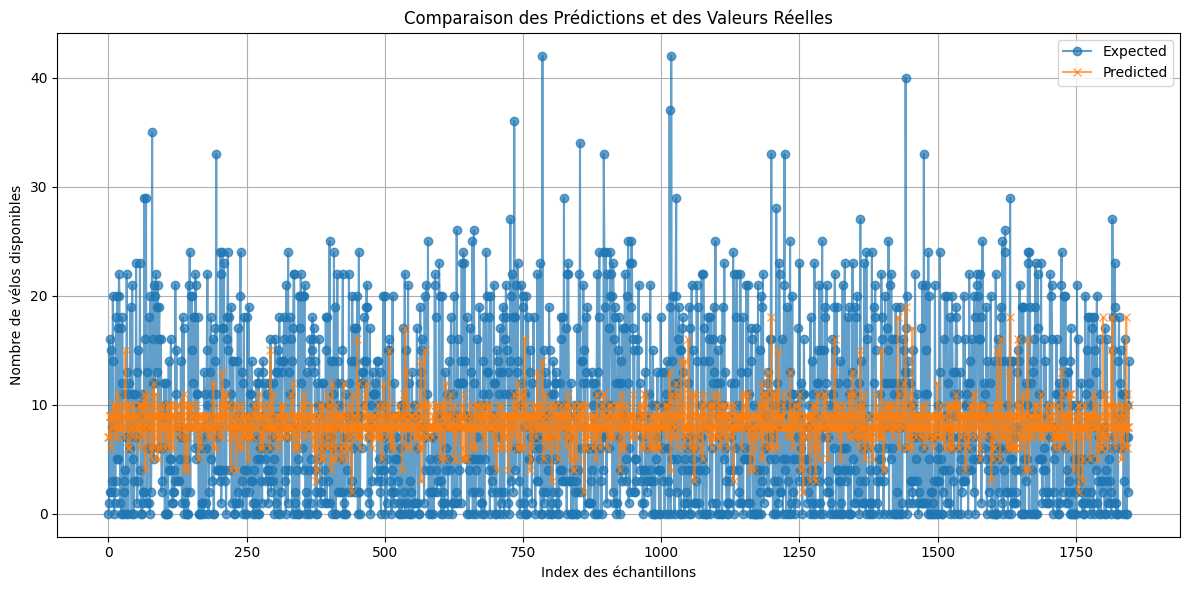

In [178]:
import matplotlib.pyplot as plt

# Tracer les résultats pour comparer les valeurs réelles et prédites
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Expected', linestyle='-', marker='o', alpha=0.7)
plt.plot(range(len(predictions)), predictions, label='Predicted', linestyle='-', marker='x', alpha=0.7)

 
plt.title("Comparaison des Prédictions et des Valeurs Réelles")
plt.xlabel("Index des échantillons")
plt.ylabel("Nombre de vélos disponibles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


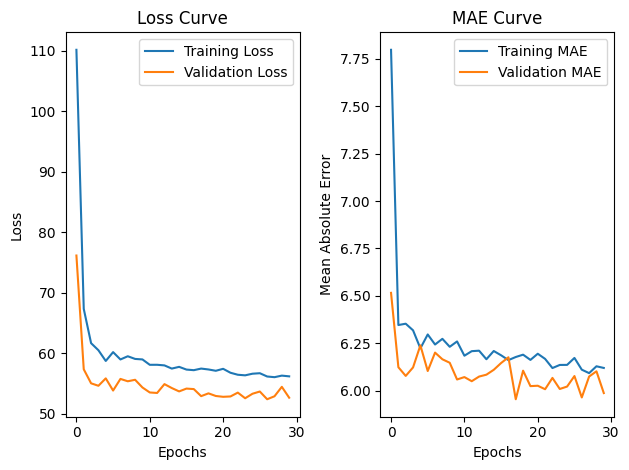

In [179]:
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe des métriques (MAE ci)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# export model scaler

In [180]:
from tensorflow.keras.models import load_model
import joblib

model.save('../models_for_cluster/cnn_model_for_cluster3.h5')
joblib.dump(scaler_x, '../scalers/scaler_X_cluster3.pkl') 


['../scalers/scaler_X_cluster3.pkl']